In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import glob
import json
import pandas as pd
import numpy as np
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
sys.path.append('..')
from utils.data import load_participant_list, get_betamap_paths

# Parameters

In [3]:
statistic = 'z_score'
multiple_comp_corr = 'fdr'
alpha = 0.05
run = 'test'
first_level_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/exclude_iti_20250221/'

# First level parameters

In [4]:
# Find the first JSON file
json_file_path = glob.glob(os.path.join(first_level_dir, '**', '*_params.json'), recursive=True)[0]

# Load and print the JSON file contents
with open(json_file_path, 'r') as file:
    json_data = json.load(file)
    for key, value in json_data.items():
        print(f"{key}: {value}")


model_name: exclude_iti
tr: 2.33384
hrf_model: spm
noise_model: ar1
smoothing_fwhm: 5
motion_type: basic
include_physio: True
brain_mask: True
fd_thresh: 0.5
std_dvars_thresh: 2
exclusion_threshold: 0.2
scrub: dummies
modulators: both
modulator_normalization: zscore
exclude_stimuli: True
duration: all
iti_included: False


# Load First level data

In [5]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)

# Look at button press

In [6]:
#betamaps_reponse_paths, _ = get_betamap_paths(sub_ids, first_level_dir, run, "sub-{sub_id}_run-{run}_betamap_first_stim_presentation_include.nii.gz")
betamaps_reponse_paths, _ = get_betamap_paths(sub_ids, first_level_dir, run, "sub-{sub_id}_run-{run}_betamap_response.nii.gz")
print('Found betamaps for', len(betamaps_reponse_paths), 'participants')

Found betamaps for 57 participants


In [7]:
betamaps_response = [image.load_img(path) for path in betamaps_reponse_paths]
X_button = pd.DataFrame([1] * len(betamaps_response), columns=['button_press'])
second_level_model_sc = SecondLevelModel().fit(betamaps_response, design_matrix=X_button)
SC_WB_zmap = second_level_model_sc.compute_contrast(output_type=statistic)

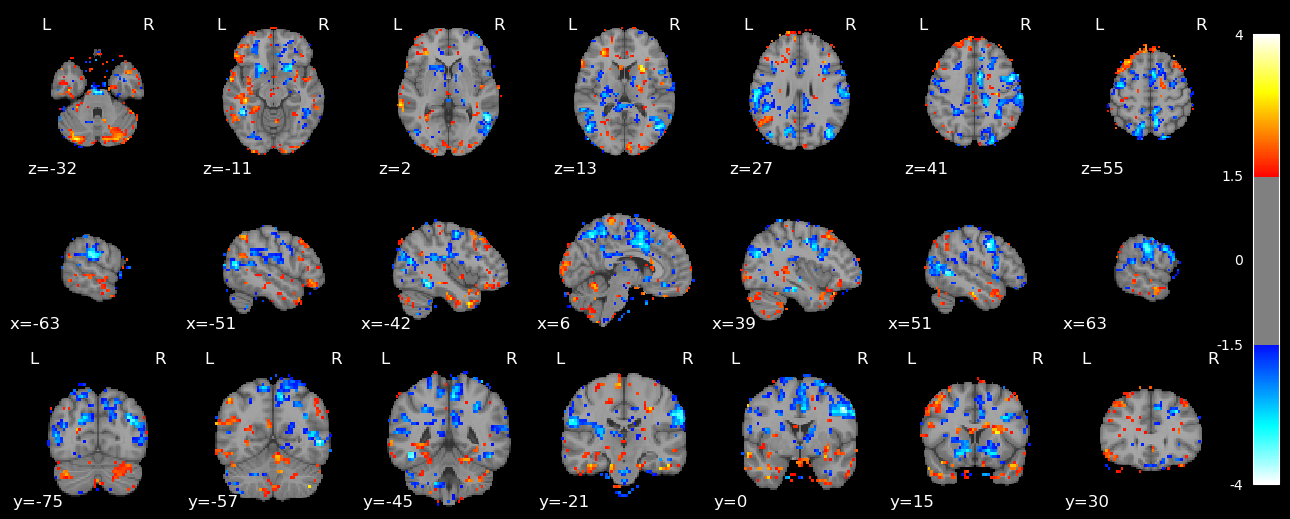

In [8]:
plot_stat_map(SC_WB_zmap, threshold=1.5, black_bg=True, display_mode='mosaic', title='')

# Look at stim presentation

In [9]:
#betamaps_reponse_paths, _ = get_betamap_paths(sub_ids, first_level_dir, run, "sub-{sub_id}_run-{run}_betamap_first_stim_presentation_include.nii.gz")
betamaps_presentation_paths, _ = get_betamap_paths(sub_ids, first_level_dir, run, "sub-{sub_id}_run-{run}_betamap_first_stim_presentation_include.nii.gz")
print('Found betamaps for', len(betamaps_presentation_paths), 'participants')

Found betamaps for 57 participants


In [10]:
betamaps_presentation= [image.load_img(path) for path in betamaps_presentation_paths]
X_presentation = pd.DataFrame([1] * len(betamaps_presentation), columns=['presentation'])
second_level_model_sc2 = SecondLevelModel().fit(betamaps_presentation, design_matrix=X_presentation)
SC2_WB_zmap = second_level_model_sc2.compute_contrast(output_type=statistic)

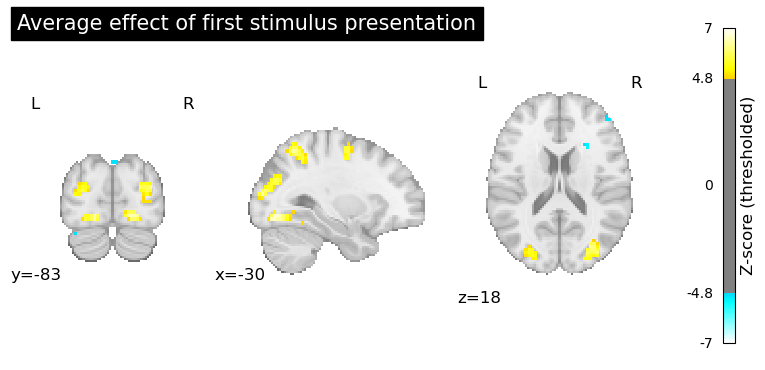

In [66]:
display = plot_stat_map(SC2_WB_zmap, threshold=4.8, black_bg=False, display_mode='ortho',
              draw_cross=False,
              title='Average effect of first stimulus presentation')
display._cbar.set_label('Z-score (thresholded)', fontsize=12)

In [12]:
SC_WB_thresholded_zmap, SC_WB_threshold = threshold_stats_img(SC2_WB_zmap, alpha=0.001, height_control='fpr',
                                                              two_sided=False)
print(f"RL whole brain threshold: {SC_WB_threshold:.3f}")

RL whole brain threshold: 3.090


# Look at 2nd level mask

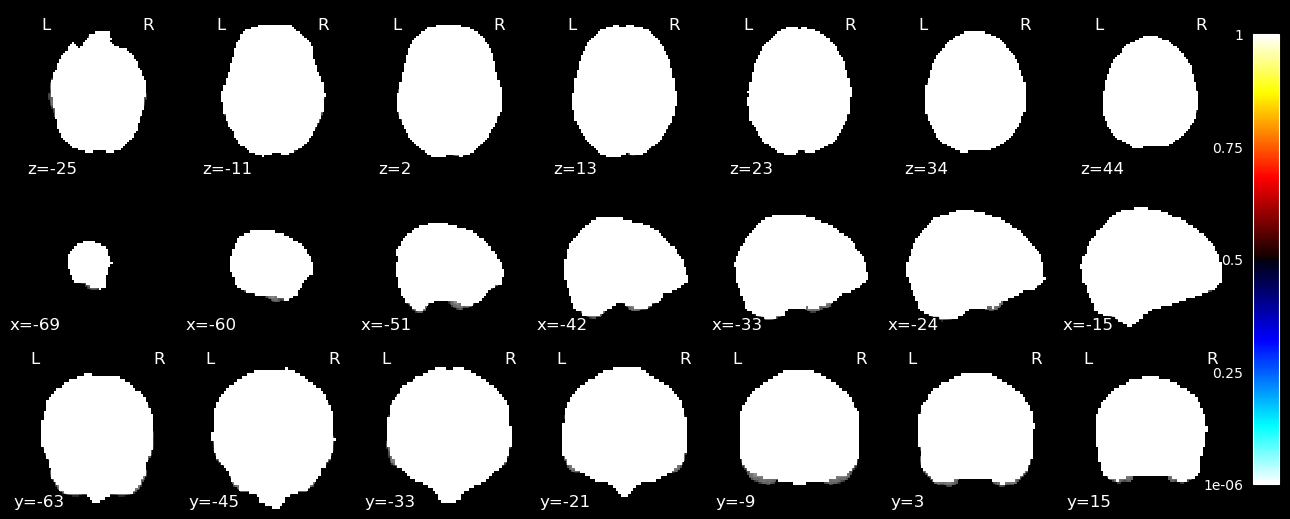

In [13]:
plot_stat_map(second_level_model_sc.masker_.mask_img_,black_bg=True, display_mode='mosaic')

# Parametric modulation

In [14]:
contrast_modulator_RL_paths, matched_sub_ids = get_betamap_paths(sub_ids, first_level_dir, run, "sub-{sub_id}_run-{run}_beta*_rl.nii.gz")
contrast_modulator_CK_paths, _ = get_betamap_paths(sub_ids, first_level_dir, run, "sub-{sub_id}_run-{run}_beta*_ck.nii.gz")

In [15]:
contrast_modulator_RL_imgs = [image.load_img(path) for path in contrast_modulator_RL_paths]
contrast_modulator_CK_imgs = [image.load_img(path) for path in contrast_modulator_CK_paths]

In [16]:
print(f"Found {len(contrast_modulator_RL_imgs)} RL and {len(contrast_modulator_CK_imgs)} CK betamaps")

Found 57 RL and 57 CK betamaps


## Load masks

In [17]:
mask_dir = '/home/ubuntu/data/learning-habits/masks'
vmpfc_mask_path = os.path.join(mask_dir, 'vmpfc_mask.nii.gz')
striatum_mask_path = os.path.join(mask_dir, 'striatum_mask.nii.gz')
putamen_mask_path = os.path.join(mask_dir, 'putamen_mask.nii.gz')
parietal_mask_path = os.path.join(mask_dir, 'parietal_mask.nii.gz')

# Q-value modulation

In [18]:
X_RL = pd.DataFrame([1] * len(contrast_modulator_RL_imgs), columns=['RL_value'])

In [19]:
second_level_model_RL = SecondLevelModel().fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

In [20]:
RL_WB_zmap = second_level_model_RL.compute_contrast(output_type=statistic)

## Whole brain

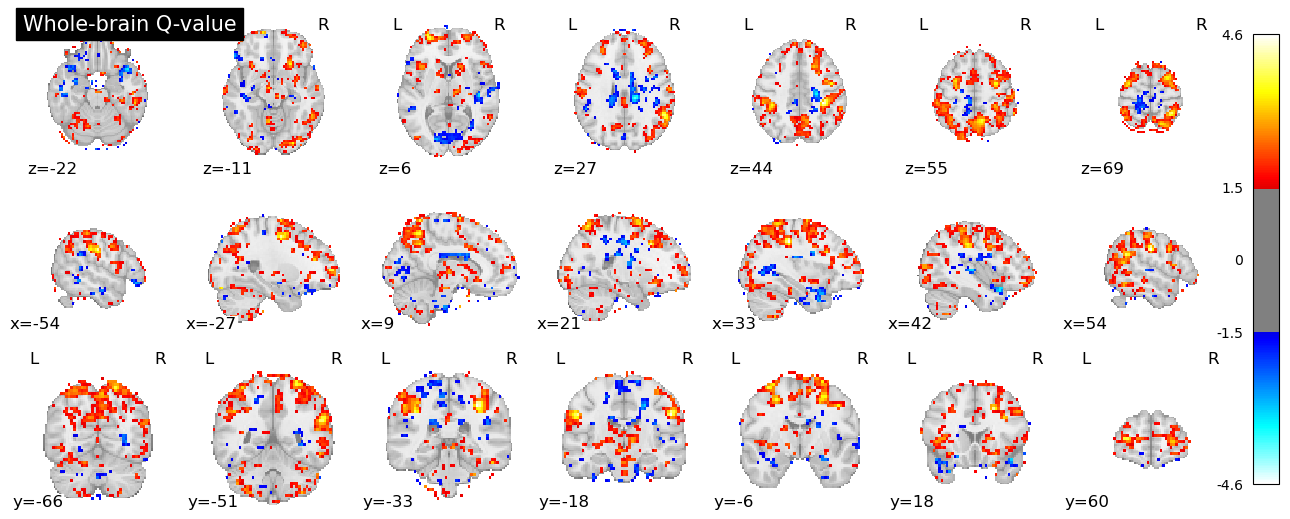

In [74]:
plot_stat_map(RL_WB_zmap,threshold=1.5, black_bg=False, display_mode='mosaic', title='Whole-brain Q-value')

### Correct for multiple comparisons

In [22]:
RL_WB_thresholded_zmap, RL_WB_threshold = threshold_stats_img(RL_WB_zmap, alpha=0.05, height_control='fdr',
                                                              two_sided=False)
print(f"RL whole brain threshold: {RL_WB_threshold:.3f}")

RL whole brain threshold: inf


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.627704030796224. But, you have given threshold=inf.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/find_cuts.py:66: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


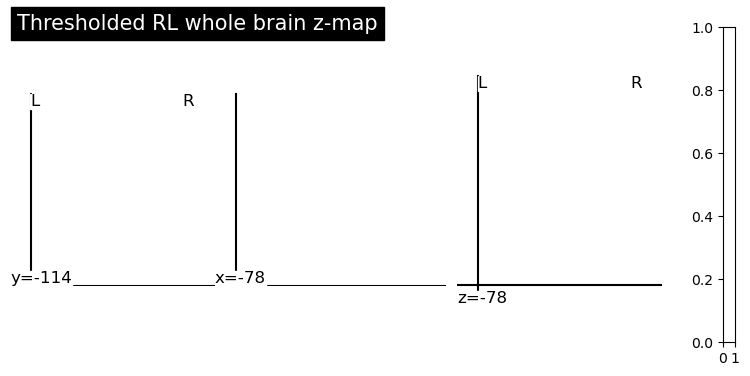

In [23]:
plot_stat_map(RL_WB_thresholded_zmap, black_bg=False, display_mode='ortho', title='Thresholded RL whole brain z-map')

## ROIs for Q-values: VMPFC

In [24]:
vmpfc_mask = image.load_img(vmpfc_mask_path)
vmpfc_mask = image.resample_to_img(vmpfc_mask, RL_WB_zmap, interpolation='nearest')
vmpfc_masker = NiftiMasker(mask_img=vmpfc_mask)

In [25]:
vmpfc_second_level = SecondLevelModel(mask_img=vmpfc_masker).fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [26]:
RL_vmpfc_zmap = vmpfc_second_level.compute_contrast(output_type=statistic)

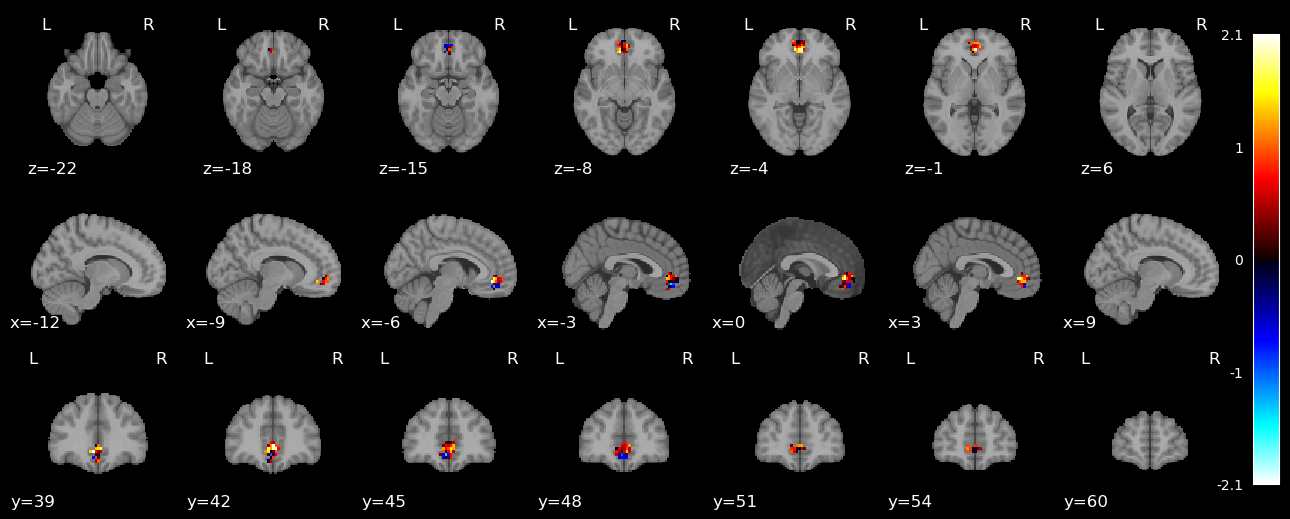

In [27]:
plot_stat_map(RL_vmpfc_zmap, black_bg=True, display_mode='mosaic', title='')

In [28]:
RL_vmpfc_thresholded_zmap, RL_vmpfc_threshold = threshold_stats_img(RL_WB_zmap,
                                                                    alpha=0.005,
                                                                    height_control='fpr',
                                                                    two_sided=False)
print(f"RL vmpfc threshold: {RL_vmpfc_threshold:.3f}")

RL vmpfc threshold: 2.576


In [29]:
RL_vmpfc_thresholded_zmap, RL_vmpfc_threshold = threshold_stats_img(RL_vmpfc_zmap,
                                                                    alpha=0.005,
                                                                    height_control='fpr',
                                                                    two_sided=False)
print(f"RL vmpfc threshold: {RL_vmpfc_threshold:.3f}")

RL vmpfc threshold: 2.576


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.0642710709749843. But, you have given threshold=2.575829303548901.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


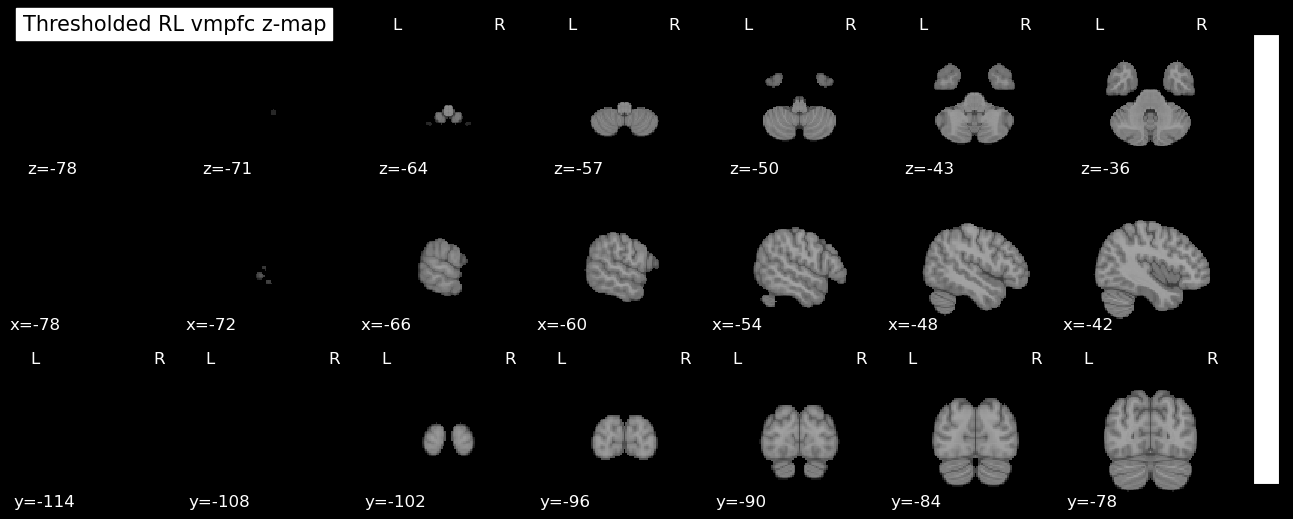

In [30]:
plot_stat_map(RL_vmpfc_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL vmpfc z-map')

In [31]:
vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)
vmpfc_table

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 2.0642710709749843. But, you have given threshold=2.575829303548901.
  stat_img = threshold_img(
/tmp/ipykernel_62173/1167065061.py:1: UserWarning: Attention: No clusters with stat higher than 2.575829303548901
  vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)
/tmp/ipykernel_62173/1167065061.py:1: UserWarning: Attention: No clusters with stat lower than -2.575829303548901
  vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


## ROIs for Q-values: Striatum

In [32]:
striatum_mask = image.load_img(striatum_mask_path)
striatum_mask = image.resample_to_img(striatum_mask, RL_WB_zmap, interpolation='nearest')
striatum_masker = NiftiMasker(mask_img=striatum_mask)

In [33]:
striatum_second_level = SecondLevelModel(mask_img=striatum_masker)
striatum_second_level = striatum_second_level.fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [34]:
vmpfc_mask.get_fdata().sum()

119.0

In [35]:
striatum_mask.get_fdata().sum()

128.0

In [36]:
RL_striatum_zmap = striatum_second_level.compute_contrast(output_type=statistic)

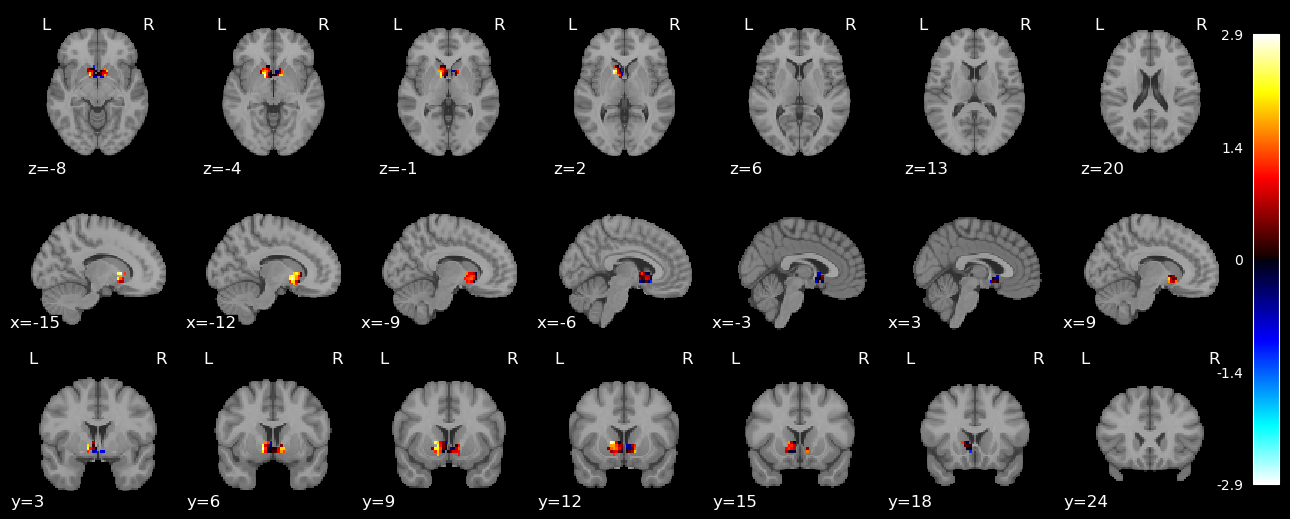

In [37]:
plot_stat_map(RL_striatum_zmap, black_bg=True, display_mode='mosaic', title='')

In [38]:
RL_striatum_thresholded_zmap, RL_striatum_threshold = threshold_stats_img(RL_striatum_zmap, alpha=0.05, height_control='fdr')
print(f"RL striatum threshold: {RL_striatum_threshold:.3f}")

RL striatum threshold: inf


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.8834940778275846. But, you have given threshold=inf.
  stat_img = threshold_img(


In [39]:
_, RL_striatum_threshold = threshold_stats_img(RL_vmpfc_zmap, alpha=0.05, height_control='fdr')
print(f"RL striatum threshold: {RL_striatum_threshold:.3f}")

RL striatum threshold: inf


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.0642710709749843. But, you have given threshold=inf.
  stat_img = threshold_img(


In [40]:
RL_striatum_thresholded_zmap, RL_striatum_threshold = threshold_stats_img(RL_striatum_zmap, mask_img = striatum_mask,alpha=0.05, height_control=None)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.8834940778275846. But, you have given threshold=3.0.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


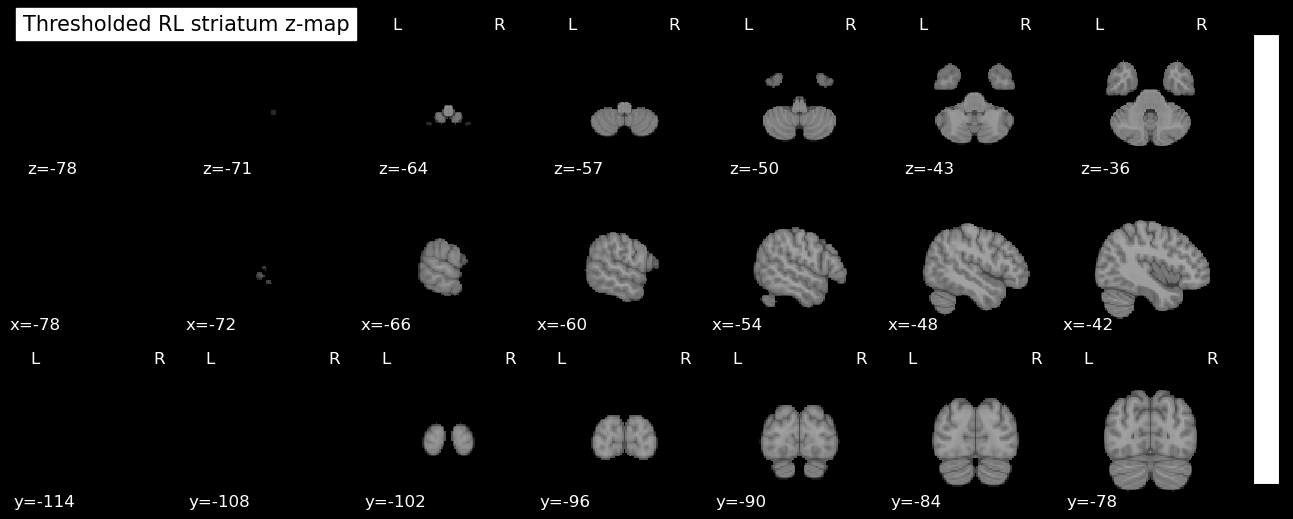

In [41]:
plot_stat_map(RL_striatum_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL striatum z-map')

In [42]:
striatum_table = get_clusters_table(RL_striatum_zmap, stat_threshold=RL_striatum_threshold, two_sided=True)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 2.8834940778275846. But, you have given threshold=3.0.
  stat_img = threshold_img(
/tmp/ipykernel_62173/2531939775.py:1: UserWarning: Attention: No clusters with stat higher than 3.0
  striatum_table = get_clusters_table(RL_striatum_zmap, stat_threshold=RL_striatum_threshold, two_sided=True)
/tmp/ipykernel_62173/2531939775.py:1: UserWarning: Attention: No clusters with stat lower than -3.0
  striatum_table = get_clusters_table(RL_striatum_zmap, stat_threshold=RL_striatum_threshold, two_sided=True)


In [43]:
striatum_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


# H-value modulation

In [44]:
X_CK = pd.DataFrame([1] * len(contrast_modulator_CK_imgs), columns=['CK_value'])

In [45]:
second_level_model_CK = SecondLevelModel()
second_level_model_CK = second_level_model_CK.fit(contrast_modulator_CK_imgs, design_matrix=X_RL)

In [46]:
CK_WB_zmap = second_level_model_CK.compute_contrast(output_type=statistic)

## Whole brain

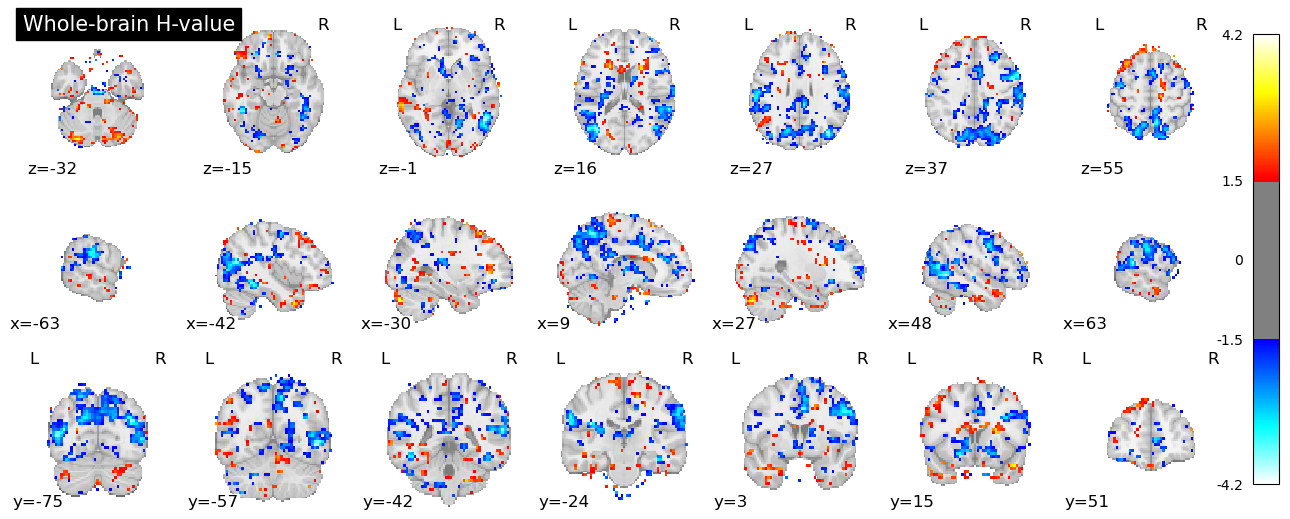

In [73]:
plot_stat_map(CK_WB_zmap, threshold=1.5, black_bg=False, display_mode='mosaic', title='Whole-brain H-value')

### Correct for multiple comparisons

In [48]:
CK_WB_thresholded_zmap, CK_WB_threshold = threshold_stats_img(CK_WB_zmap, alpha=0.05, height_control='fpr', cluster_threshold=5)
print(f"CK whole brain threshold: {CK_WB_threshold:.3f}")

CK whole brain threshold: 1.960


In [49]:
np.corrcoef(CK_WB_zmap.get_fdata().flatten(), RL_WB_zmap.get_fdata().flatten())

array([[ 1.        , -0.30613798],
       [-0.30613798,  1.        ]])

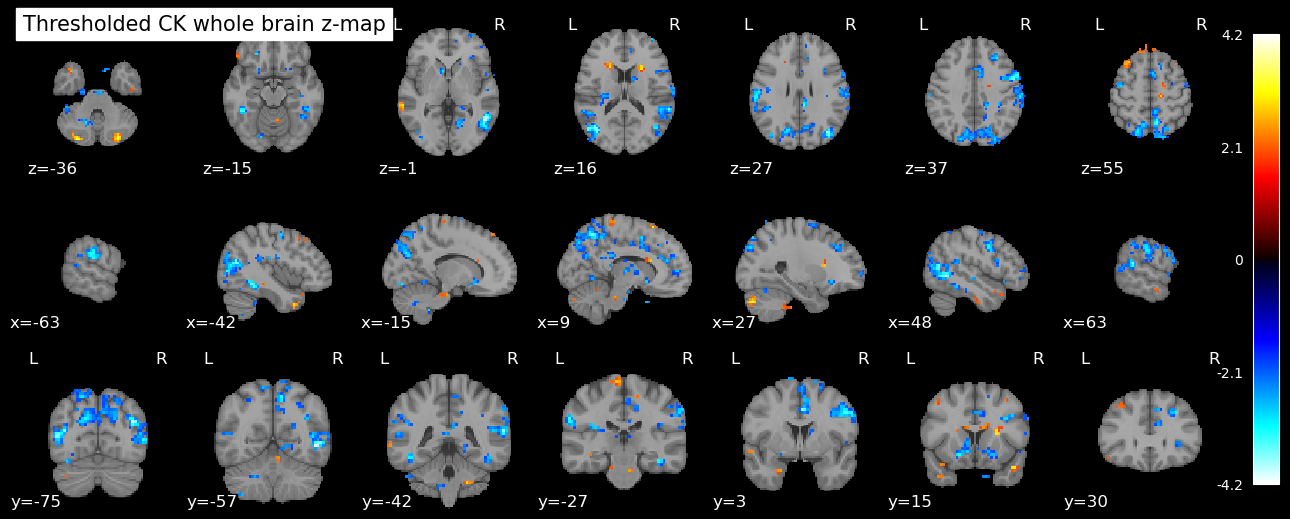

In [50]:
plot_stat_map(CK_WB_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK whole brain z-map')

## ROIs for H-values: putamen

In [51]:
putamen_mask = image.load_img(putamen_mask_path)
putamen_mask = image.resample_to_img(putamen_mask, RL_WB_zmap, interpolation='nearest')
putamen_masker = NiftiMasker(mask_img=putamen_mask)

In [52]:
putamen_second_level = SecondLevelModel(mask_img=putamen_masker)
putamen_second_level = putamen_second_level.fit(contrast_modulator_CK_imgs, design_matrix=X_CK)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [53]:
CK_putamen_zmap = putamen_second_level.compute_contrast(output_type=statistic)

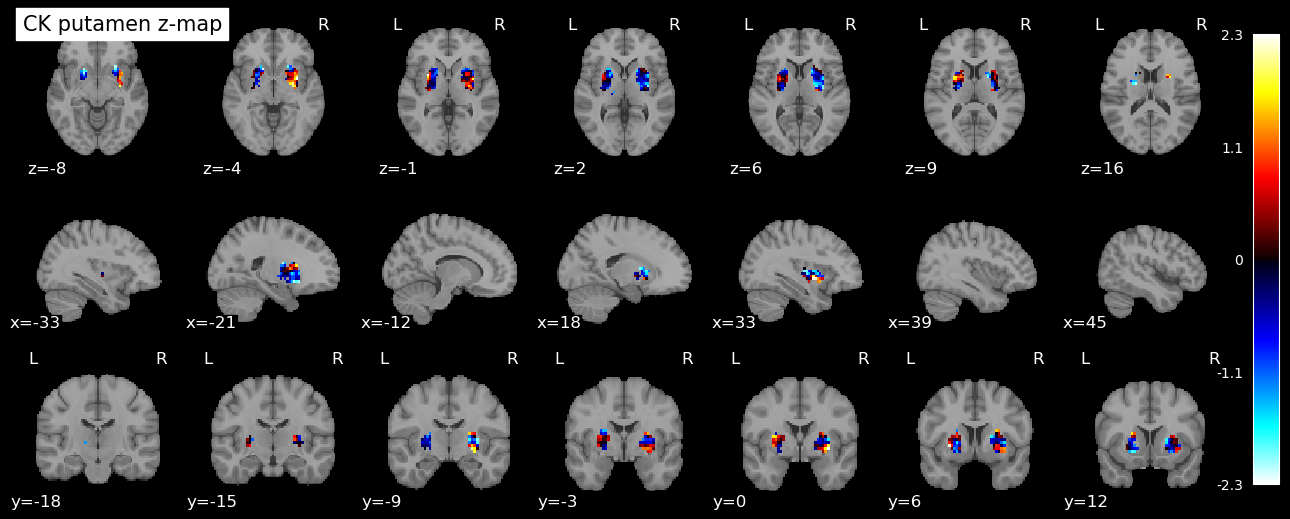

In [54]:
plot_stat_map(CK_putamen_zmap, black_bg=True, display_mode='mosaic', title='CK putamen z-map')

In [55]:
CK_putamen_thresholded_zmap, CK_putamen_threshold = threshold_stats_img(CK_putamen_zmap, alpha=alpha, height_control='fdr')

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.2602226688391758. But, you have given threshold=inf.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


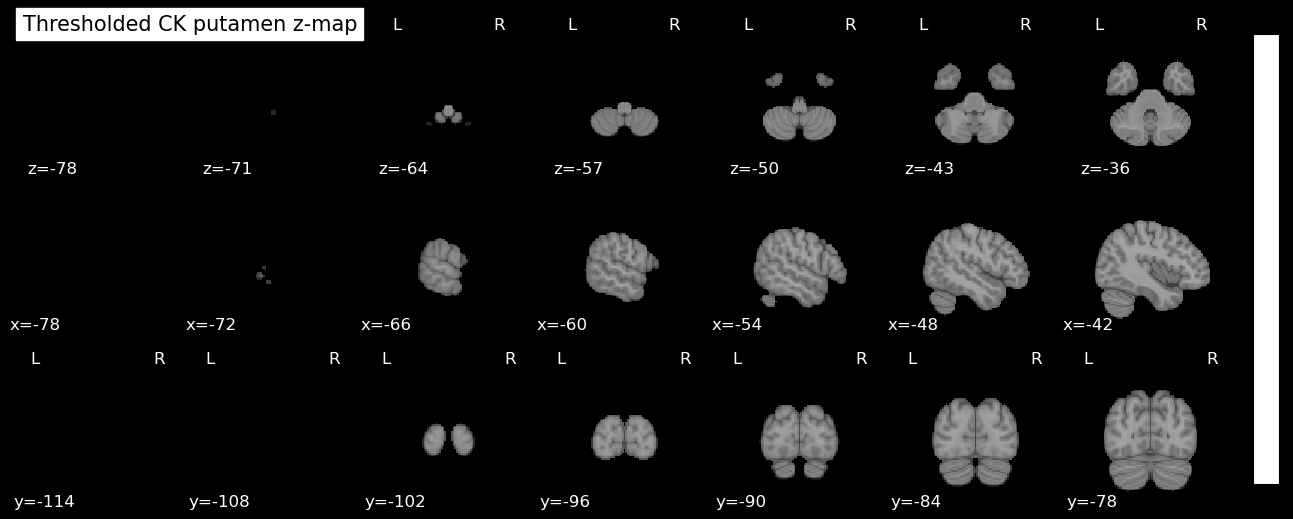

In [56]:
plot_stat_map(CK_putamen_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK putamen z-map')

In [57]:
putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)
putamen_table

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 2.2602226688391758. But, you have given threshold=inf.
  stat_img = threshold_img(
/tmp/ipykernel_62173/2590643497.py:1: UserWarning: Attention: No clusters with stat higher than inf
  putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)
/tmp/ipykernel_62173/2590643497.py:1: UserWarning: Attention: No clusters with stat lower than -inf
  putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


## ROIs for H-values: parietal cortex

In [58]:
parietal_mask = image.load_img(parietal_mask_path)
parietal_mask = image.resample_to_img(parietal_mask, RL_WB_zmap, interpolation='nearest')
parietal_masker = NiftiMasker(mask_img=parietal_mask)

In [59]:
parietal_second_level = SecondLevelModel(mask_img=parietal_masker)
parietal_second_level = parietal_second_level.fit(contrast_modulator_CK_imgs, design_matrix=X_CK)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [60]:
CK_parietal_zmap = parietal_second_level.compute_contrast(output_type=statistic)

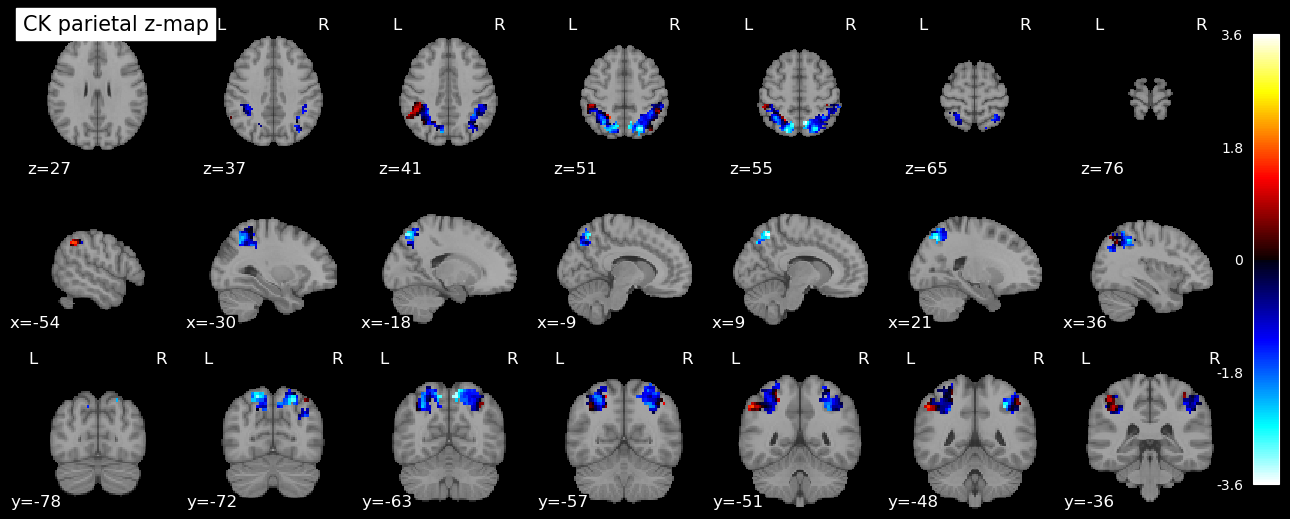

In [61]:
plot_stat_map(CK_parietal_zmap, black_bg=True, display_mode='mosaic', title='CK parietal z-map')

In [62]:
CK_parietal_thresholded_zmap, CK_parietal_threshold = threshold_stats_img(CK_parietal_zmap, alpha=alpha, height_control=multiple_comp_corr)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.575665174140626. But, you have given threshold=inf.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


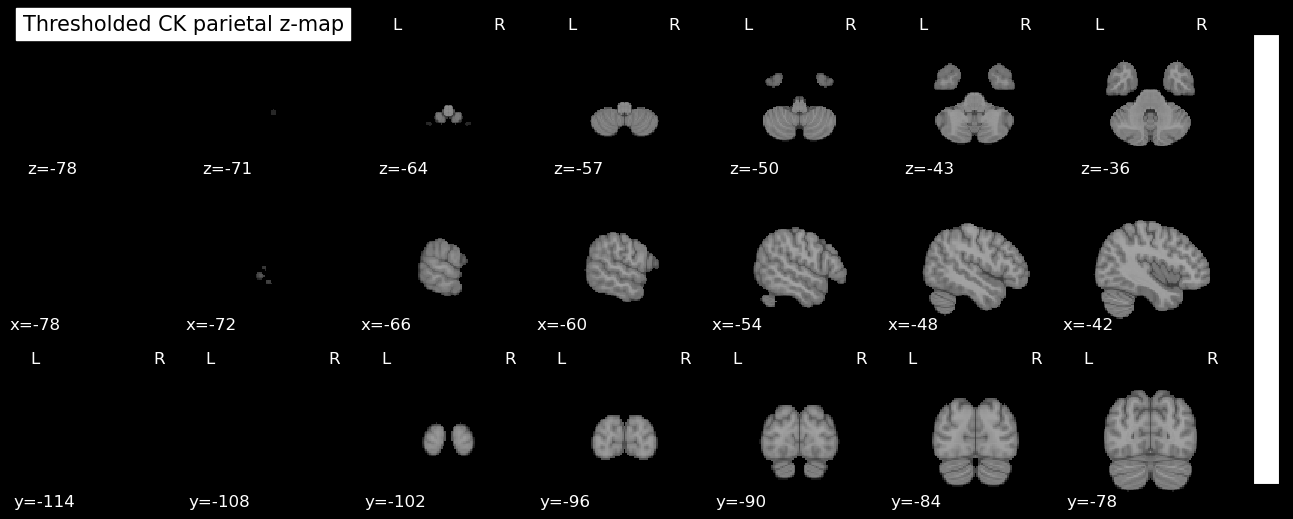

In [63]:
plot_stat_map(CK_parietal_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK parietal z-map')

In [64]:
parietal_table = get_clusters_table(CK_parietal_zmap, stat_threshold=CK_parietal_threshold, two_sided=True)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 3.575665174140626. But, you have given threshold=inf.
  stat_img = threshold_img(
/tmp/ipykernel_62173/2125408686.py:1: UserWarning: Attention: No clusters with stat higher than inf
  parietal_table = get_clusters_table(CK_parietal_zmap, stat_threshold=CK_parietal_threshold, two_sided=True)
/tmp/ipykernel_62173/2125408686.py:1: UserWarning: Attention: No clusters with stat lower than -inf
  parietal_table = get_clusters_table(CK_parietal_zmap, stat_threshold=CK_parietal_threshold, two_sided=True)


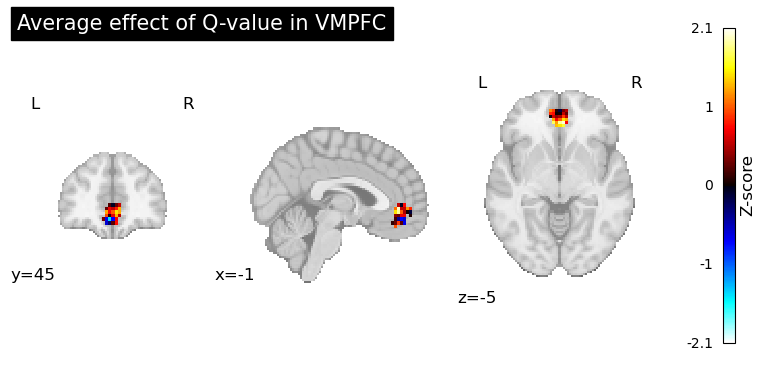

In [67]:
from nilearn import plotting
# First, plot your stat map and keep the display object
display = plotting.plot_stat_map(
    RL_vmpfc_zmap,
    black_bg=False,
    display_mode='ortho',
    title='Average effect of Q-value in VMPFC',
    draw_cross=False
)
# Access the colorbar and set the label
display._cbar.set_label('Z-score', fontsize=12)
# # Then, add your mask overlay (semi-transparent by default)
# display.add_contours(
#     vmpfc_mask,
#     colors='black',     # Or a list of colors if you want to vary
#     linewidths=.1
# )

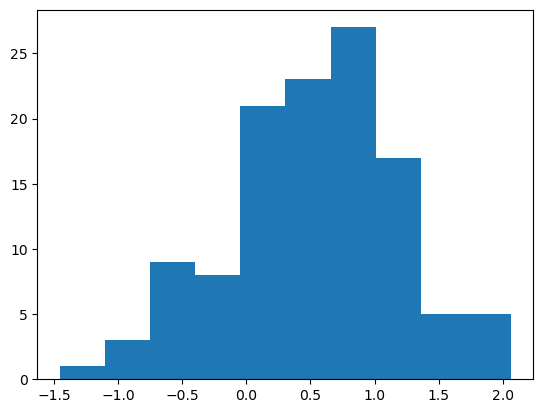

In [81]:
from matplotlib import pyplot as plt
data = RL_vmpfc_zmap.get_fdata().ravel()
plt.hist(data[data != 0])
plt.show()

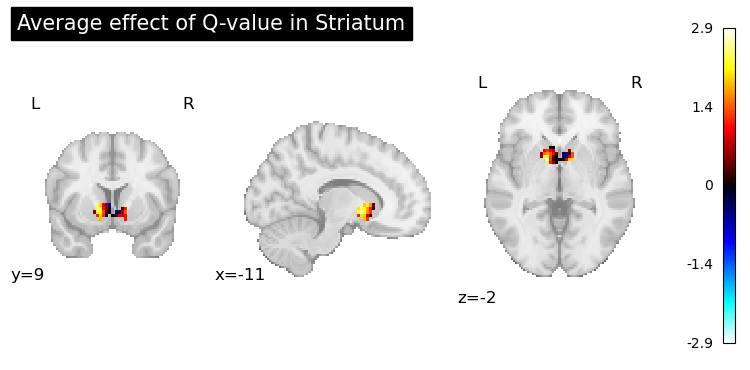

In [68]:
display = plotting.plot_stat_map(
    RL_striatum_zmap,
    black_bg=False,
    display_mode='ortho',
    title='Average effect of Q-value in Striatum',
    draw_cross=False
)

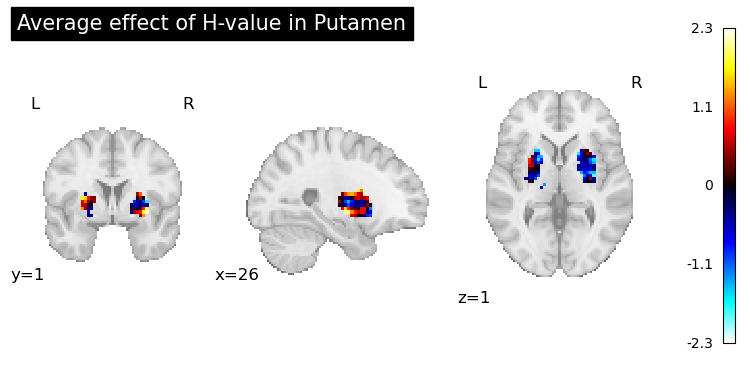

In [69]:
display = plotting.plot_stat_map(
    CK_putamen_zmap,
    black_bg=False,
    display_mode='ortho',
    title='Average effect of H-value in Putamen',
    draw_cross=False
)

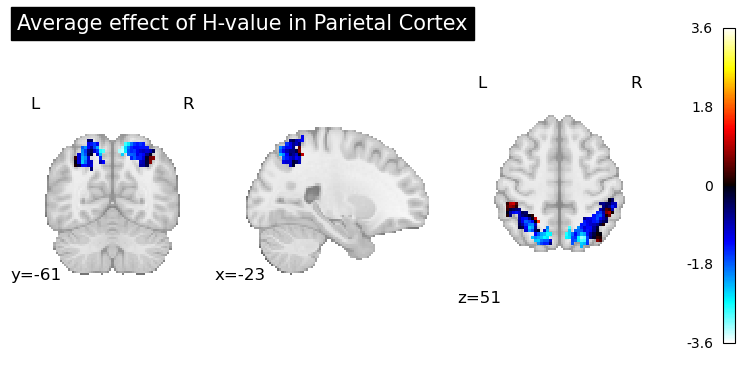

In [70]:
display = plotting.plot_stat_map(
    CK_parietal_zmap,
    black_bg=False,
    display_mode='ortho',
    title='Average effect of H-value in Parietal Cortex',
    draw_cross=False
)

# ROI results

In [ ]:
vmpfc_table

In [ ]:
# Add ROI information to each table
vmpfc_table['ROI'] = 'VMPFC'
striatum_table['ROI'] = 'Striatum'
putamen_table['ROI'] = 'Putamen'
parietal_table['ROI'] = 'Parietal Cortex'

# Combine the tables
combined_table = pd.concat([vmpfc_table, striatum_table, putamen_table, parietal_table])
combined_table['Coordinates (MNI)'] = combined_table[['X', 'Y', 'Z']].apply(lambda row: tuple(row), axis=1)
combined_table = combined_table[['ROI', 'Cluster ID', 'Coordinates (MNI)', 'Cluster Size (mm3)', 'Peak Stat']]

# Filter out secondary peaks
combined_table = combined_table[~combined_table['Cluster ID'].str.contains('[a-zA-Z]', na=False)]

In [ ]:
voxel_volume = np.prod(np.abs(np.diag(RL_WB_zmap.affine)[:3]))
voxel_volume

In [ ]:
combined_table['Cluster Size (voxels)'] = np.round(combined_table['Cluster Size (mm3)'].astype('float') / voxel_volume).astype('int')
combined_table

In [ ]:
# to see number of voxels in each mask:
np.unique(vmpfc_mask.get_fdata(), return_counts=True)

In [ ]:
final_table = combined_table.copy()
final_table = final_table[final_table['Cluster Size (voxels)'] >= 10]
final_table

In [ ]:
#final_table.to_csv('final_table.csv', index=False)

# Saving Figures

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# # maps to save:
# maps = {
#     'Q_val_wholebrain_zmap': RL_WB_zmap,
#     'Q_val_vmpfc_zmap': RL_vmpfc_zmap,
#     'Q_val_striatum_zmap': RL_striatum_zmap,
#     'H_val_wholebrain_zmap': CK_WB_zmap,
#     'H_val_putamen_zmap': CK_putamen_zmap,
#     'H_val_parietal_zmap': CK_parietal_zmap
#     }

In [ ]:
# output_dir = '/home/ubuntu/data/learning-habits/outputs/figures'
# for name, map in maps.items():
#     fig = plt.figure(figsize=(12, 8))
#     display = plot_stat_map(map, 
#                             display_mode='mosaic',
#                             threshold=2 if 'wholebrain' in name else 1e-6,
#                             figure=fig)
#     display.savefig(os.path.join(output_dir, f'{name}.png'), dpi=300)